<h1 style=font:garmond;font-size:50px;color:orange;text-align:left>Predict ML</h1>

In [24]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List
from sklearn.preprocessing import StandardScaler
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
from main import Lottery, Review, Timer

<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Transformation</h2>

In [25]:
base_df = pd.read_csv('data.csv', names=['A', 'B', 'C', 'D', 'E', 'F'])
df = base_df.iloc[:-1]
# Using all but final row of dataframe for model, and final row as target for testing and model validation
scaler = StandardScaler().fit(df.values)
transformed_dataset = scaler.transform(df.values)
transformed_dataframe = pd.DataFrame(data=transformed_dataset, index=df.index)

In [26]:
number_of_rows: int = df.values.shape[0]
number_of_features: int = df.values.shape[1]
window_size: int = 14

In [27]:
train = np.empty([number_of_rows-window_size, window_size, number_of_features], dtype=float)
label = np.empty([number_of_rows-window_size, number_of_features], dtype=float)

for i in range(0, number_of_rows-window_size):
    train[i]=transformed_dataframe.iloc[i:i+window_size, 0: number_of_features]
    label[i]=transformed_dataframe.iloc[i+window_size: i+window_size+1, 0: number_of_features]

# print(f'{train.shape=}\n{label.shape=}')

<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Training</h2>

In [28]:
LSTM_NODES: int = 240
DENSE_LAYERS: int = 6
DROPOUT_VARIANCE: float = 0.2

In [29]:
model = Sequential()
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Dropout(DROPOUT_VARIANCE))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Dropout(DROPOUT_VARIANCE))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=False)))
model.add(Dense(DENSE_LAYERS))
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])    # NOQA

In [30]:
timer = Timer()
timer.start()

batch_size: int = 28
epochs: int = 5

history = model.fit(train, label, batch_size=batch_size, epochs=epochs)

timer.stop()

Epoch 1/5
74/74 [==============================] - 18s 107ms/step - loss: 1.0185 - accuracy: 0.1913
Epoch 2/5
74/74 [==============================] - 6s 76ms/step - loss: 1.0035 - accuracy: 0.1719
Epoch 3/5
74/74 [==============================] - 6s 76ms/step - loss: 1.0032 - accuracy: 0.1918
Epoch 4/5
74/74 [==============================] - 6s 74ms/step - loss: 1.0009 - accuracy: 0.1700
Epoch 5/5
74/74 [==============================] - 5s 74ms/step - loss: 0.9988 - accuracy: 0.1656
Time taken: 40.32s


<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Prediction</h2>


In [31]:
timer.start()

to_predict = np.array(df)
scaled_to_predict = scaler.transform(to_predict)

scaled_prediction = model.predict(np.array([scaled_to_predict]))
np_prediction: List[int] = scaler.inverse_transform(scaled_prediction).astype(int)[0]

print(*np_prediction, sep=', ')
timer.stop()

1/1 [==============================] - 54s 54s/step
6, 12, 18, 24, 30, 36
Time taken: 54.272s


<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Result</h2>

In [32]:
prediction = list(np_prediction)
target = list(base_df.iloc[-1])
# Using all but final row of dataframe for model, and final row as target

# target: List[int] = Lottery(len(df)+2).collect(timer=True)
# Above using Lottery class to get draw result, however this is only to be used for functional methods once model is validated

quality = Review(prediction, target)
quality.show()

Prediction: 6, 12, 18, 24, 30, 36
Target: 5, 9, 14, 25, 30, 35


In [33]:
with open('predictions.csv', 'a', encoding='UTF-8', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(np_prediction)

column_names: List[str] = ['A', 'B', 'C', 'D', 'E', 'F']
df2 = pd.read_csv('predictions.csv', names=column_names)

print(df2.iloc[-6:])

   A   B   C   D   E   F
0  5  12  18  24  30  36
1  6  12  18  24  30  36
2  6  12  17  24  30  36
3  6  12  18  24  30  36


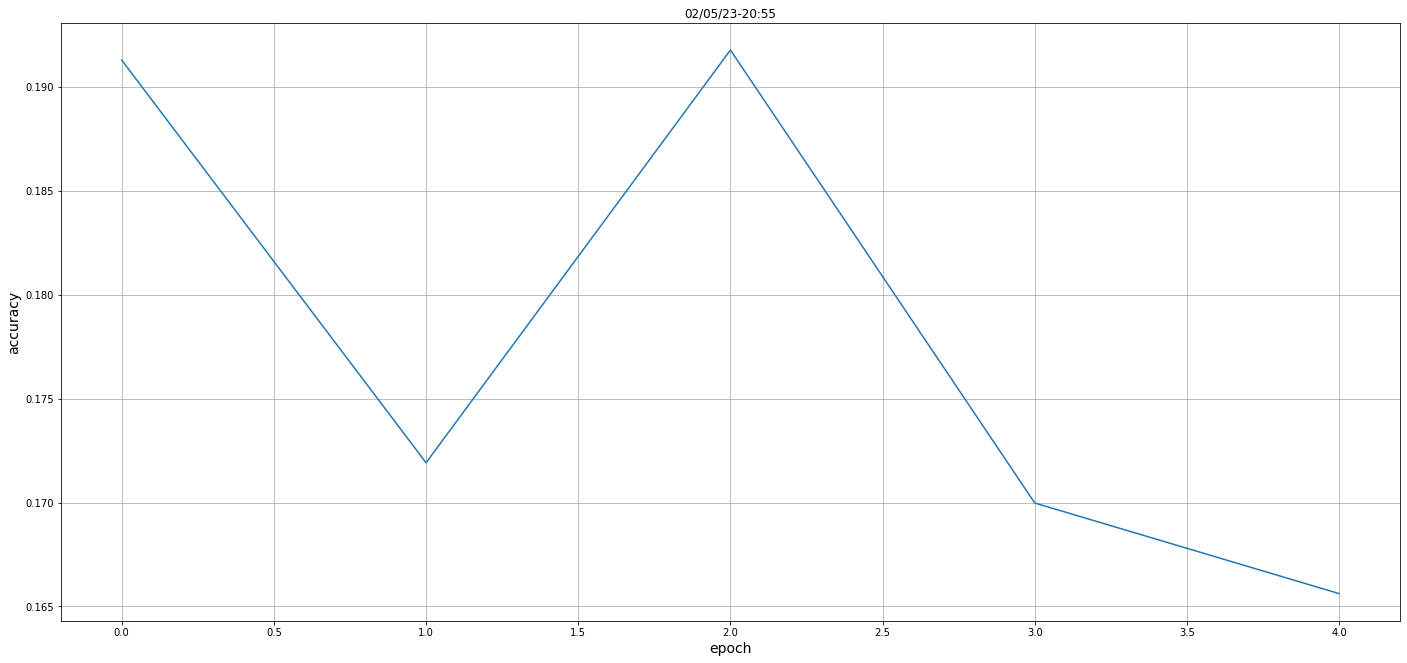

In [34]:
today: datetime = datetime.today()
now: datetime = datetime.now()

date_formatted: str = today.strftime('%m/%d/%y')
time_formatted: str = now.strftime('%H:%M')
title: str = f'{date_formatted}-{time_formatted}'

plt.figure(figsize=(24, 11))
plt.plot(history.history['accuracy'])
plt.title(title)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.grid()
plt.show()